In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

/Users/max/Documents/tsfresh/venv/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


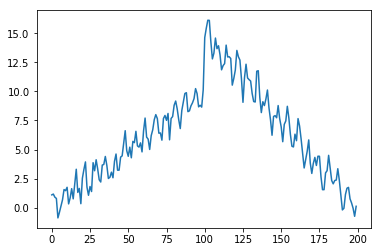

In [2]:
x_up = np.arange(100)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x_down = np.arange(100, 0, -1)*0.15 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x = np.concatenate([x_up, x_down])
#x = np.arange(10)+5, "AA"
plt.plot(x)
plt.show()

In [3]:
df_shift, y = make_forecasting_frame(x, kind="price", 
                               maximum_number_of_timeshifts=10, 
                               rolling_direction=1)

In [4]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="val", 
                     impute_function=impute)

Feature Extraction: 100%|██████████| 199/199 [00:02<00:00, 90.15it/s]
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'feature__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'feature__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rval

In [5]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :])

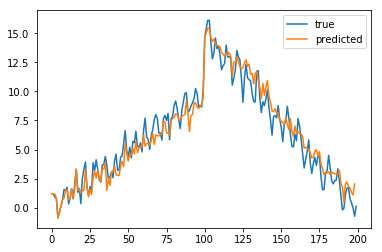

In [6]:
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()